In [22]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [3]:
#!pip install -U "tensorflow-text==2.13.*"

In [23]:
df = pd.read_csv('./spam.csv')
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [24]:
# Group by Catagory 
df.groupby('Category').describe()

# ham 4825 and spam 747 so there are imbalance in dataset 

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [25]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

# thre is imbalance in dataset 
# Do wownsample ham to 747 randomply, there is lost in training data in this approach

In [26]:
# get only the spam's
df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [27]:
# get only the ham
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [28]:
# downsample ham dataset
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [29]:
# now concatenate the dataset which has ham and smap balanced
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [30]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

# Create a new column call spam and set 1 or 0 for true and false

In [31]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)

In [32]:
df_balanced.sample(10)

,Category,Message,spam
1492,spam,Your account has been credited with 500 FREE T...,1
520,ham,Usually the person is unconscious that's in ch...,0
1830,spam,Hottest pics straight to your phone!! See me g...,1
1874,spam,You have WON a guaranteed £1000 cash or a £200...,1
44,ham,Great! I hope you like your man well endowed. ...,0
3906,spam,Do you want a new video handset? 750 anytime a...,1
2354,spam,Please CALL 08712402902 immediately as there i...,1
5141,spam,FREE for 1st week! No1 Nokia tone 4 ur mobile ...,1
2677,ham,* Am on a train back from northampton so i'm a...,0
3562,spam,Text BANNEDUK to 89555 to see! cost 150p texto...,1


# Create traininng and test dataset usning sklearn

In [33]:
from sklearn.model_selection import train_test_split
# df_balanced to get equal number of spam and ham distributed in the split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify=df_balanced['spam']) 

In [34]:
X_train.sample(10)

93      Please call our customer service representativ...
78             Does not operate after  &lt;#&gt;  or what
2693    Urgent Urgent! We have 800 FREE flights to Eur...
1778    Buy Space Invaders 4 a chance 2 win orig Arcad...
2153    Hi kindly give us back our documents which we ...
3207                                        At home also.
1456    Summers finally here! Fancy a chat or flirt wi...
3765    Would me smoking you out help us work through ...
5068    83039 62735=£450 UK Break AccommodationVoucher...
5196    Spook up your mob with a Halloween collection ...
Name: Message, dtype: object

In [35]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [36]:
def get_sentence_embeding(sentences):
    preprocesed_text=bert_preprocess(sentences)
    return bert_encoder(preprocesed_text)['pooled_output']


get_sentence_embeding(['Hurry there are 50% discount on Apple decives',
                       'Manoje is happy with his new bike'])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.76042193, -0.4264824 , -0.773927  , ..., -0.4866681 ,
        -0.632334  ,  0.7241167 ],
       [-0.79849166, -0.5656234 , -0.9235822 , ..., -0.5869544 ,
        -0.60568583,  0.86320144]], dtype=float32)>

# Test to check similarities between words

In [37]:
e = get_sentence_embeding([
    'Apple',
    'Orange',
    'Grapes',
    'Elon Mask',
    'Ratan Tata',
    'Satya Nadal'
])
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.8196456 , -0.29609603,  0.20951797, ...,  0.255934  ,
        -0.5874298 ,  0.8434556 ],
       [-0.8363078 , -0.23830146,  0.38453507, ...,  0.45564735,
        -0.6078617 ,  0.82788914],
       [-0.86023223, -0.2124296 ,  0.49156845, ...,  0.39797997,
        -0.6050631 ,  0.8447167 ],
       [-0.8967278 , -0.42045587, -0.38606298, ..., -0.13228925,
        -0.6666912 ,  0.9103784 ],
       [-0.77388406, -0.18204877,  0.37464592, ...,  0.393602  ,
        -0.46606255,  0.701598  ],
       [-0.8693092 , -0.44143924, -0.15674907, ..., -0.17136651,
        -0.58713514,  0.8397913 ]], dtype=float32)>

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[4]], [e[5]])

array([[0.8981739]], dtype=float32)

# Create the functional model

In [40]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [42]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


model.compile(optimizer='adam',
             loss='binary_crossentropy',
              metrics=METRICS
             )

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 161s 4s/step - loss: 0.5860 - accuracy: 0.7268 - precision: 0.7309 - recall: 0.7179
Epoch 2/5
35/35 [==============================] - 162s 5s/step - loss: 0.4780 - accuracy: 0.8205 - precision: 0.8100 - recall: 0.8375
Epoch 3/5
35/35 [==============================] - 162s 5s/step - loss: 0.4197 - accuracy: 0.8554 - precision: 0.8339 - recall: 0.8875
Epoch 4/5
35/35 [==============================] - 160s 5s/step - loss: 0.3822 - accuracy: 0.8705 - precision: 0.8621 - recall: 0.8821
Epoch 5/5
35/35 [==============================] - 168s 5s/step - loss: 0.3551 - accuracy: 0.8696 - precision: 0.8485 - recall: 0.9000


In [43]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 54s 4s/step - loss: 0.3425 - accuracy: 0.8984 - precision: 0.8901 - recall: 0.9091


[0.34249258041381836,
 0.8983957171440125,
 0.8900523781776428,
 0.9090909361839294]

In [44]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.6487068 ],
       [0.72458136],
       [0.7140499 ],
       [0.24172936],
       [0.1720283 ]], dtype=float32)

In [45]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted 

12/12 [==============================] - 53s 4s/step


array([0.14780243, 0.83616966, 0.895681  , 0.60874975, 0.79752743,
       0.18940517, 0.20724918, 0.7186338 , 0.8110584 , 0.29038918,
       0.06002934, 0.67704606, 0.26803395, 0.02421906, 0.23633616,
       0.6713668 , 0.5536636 , 0.40734163, 0.96772015, 0.09920922,
       0.8884241 , 0.67537236, 0.91609436, 0.4696977 , 0.73928213,
       0.74214894, 0.27588227, 0.07367647, 0.12782654, 0.5778067 ,
       0.8324596 , 0.2196789 , 0.45493597, 0.19588299, 0.7866631 ,
       0.7048098 , 0.11822686, 0.7637519 , 0.9273894 , 0.63355464,
       0.549252  , 0.63056713, 0.06819544, 0.21523462, 0.66108394,
       0.72026026, 0.8240072 , 0.5442623 , 0.16691075, 0.18464717,
       0.08623861, 0.18891117, 0.735622  , 0.36061302, 0.58253664,
       0.8447066 , 0.0939879 , 0.19880396, 0.38330156, 0.42071605,
       0.90478134, 0.22045818, 0.8760938 , 0.8760052 , 0.20388818,
       0.53143543, 0.8398846 , 0.16708907, 0.6247618 , 0.47059914,
       0.0551592 , 0.85209197, 0.81117636, 0.68284196, 0.38071

In [47]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5 ,1 ,0)
y_predicted

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,

In [48]:
from sklearn.metrics import confusion_matrix, classification_report 

cm = confusion_matrix(y_test, y_predicted)
cm

array([[166,  21],
       [ 17, 170]])

Text(50.722222222222214, 0.5, 'Truth')

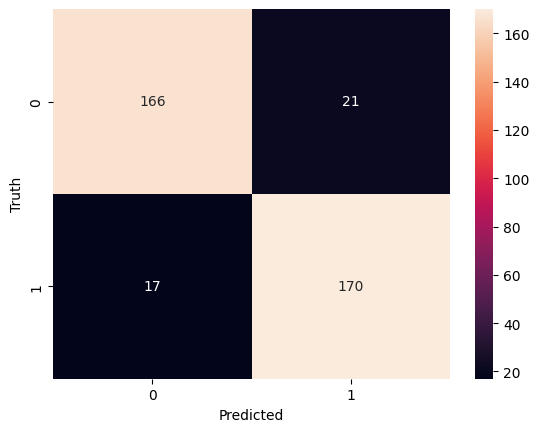

In [49]:
from matplotlib import pyplot as plt
import seaborn as sn

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [50]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       187
           1       0.89      0.91      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



# Inference

In [52]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
inferered = model.predict(reviews)

1/1 [==============================] - 1s 729ms/step


In [54]:
inferered = np.where(inferered > 0.5, 1, 0)
inferered = inferered.flatten()
inferered

array([1, 1, 1, 0, 0])